In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
from torchsummary import summary
import model

In [2]:
path = "/media/eddy/datasets/models/"
path_full_together = path + "birdnet_g5_d5_tog/birdnet_final.pt"
path_full_separated = path + "birdnet_g5_d5_sep/birdnet_final.pt"

In [3]:
def get_distribution(load_path):
    softmax = torch.nn.Softmax(dim=0)
    checkpoint = torch.load(load_path)
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    
    mean_scale_list = []
    var_scale_list = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        
        scaling_factor = re.search(pattern_scaling_factor, key)
        
        if bn_3:
            values = weights[key]
            mean_scale_list[-1][1] = torch.mean(values).cpu()
            var_scale_list[-1][1] = torch.var(values).cpu()
        if bn_7:
            values = weights[key]
            mean_scale_list[-1][2] = torch.mean(values).cpu()
            var_scale_list[-1][2] = torch.var(values).cpu()

        if scaling_factor:
            value = weights[key]
            value = softmax(value)
            mean_scale_list.append([value[0].cpu(),0,0])
            var_scale_list.append([value[0].cpu(),0,0])
    return mean_scale_list, var_scale_list

In [4]:
def plot_distribution(load_path, save_path):
    mean_scale_list, var_scale_list = get_distribution(load_path)
    x = [elem[0] for elem in mean_scale_list]
    y1 = [elem[1] for elem in mean_scale_list]
    y2 = [elem[2] for elem in mean_scale_list]
    y3 = [elem[1] for elem in var_scale_list]
    y4 = [elem[2] for elem in var_scale_list]
    
    #print(x)
    #print(y1)
    #print(y2)
    coeff1 = np.corrcoef(x, y1)
    coeff2 = np.corrcoef(x, y2)
    #coeff3 = np.corrcoef(y1, y2)
    
    print("Korrelationskoeffizient scaling factor - Durschnitt bn layer 1: " + str(coeff1[0][1]))
    print("Korrelationskoeffizient scaling factor - Durschnitt bn layer 2: " + str(coeff2[0][1]))
    #print(coeff3)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel('block scaling factor')
    ax.set_ylabel('mean channel scaling factor')
    ax.scatter(x,y1)
    ax.scatter(x,y2, marker="x")
    #ax.scatter(x,y3, marker="<")
    #ax.scatter(x,y4, marker=">")
    ax.legend(["Conv Layer 1 mean", "Conv Layer 2 mean", "Conv Layer 1 var", "Conv Layer 2 var"])
    plt.savefig(save_path)

In [5]:
def plot_distribution_layer_wise(load_path, save_path):
    mean_scale_list, var_scale_list = get_distribution(load_path)
    x = [range(0, len(mean_scale_list))]
    y0 = [elem[0] for elem in mean_scale_list]
    y1 = [elem[1] for elem in mean_scale_list]
    y2 = [elem[2] for elem in mean_scale_list]
    y3 = [elem[1] for elem in var_scale_list]
    y4 = [elem[2] for elem in var_scale_list]
    
    coeff0 = np.corrcoef(x, y0)
    coeff1 = np.corrcoef(x, y1)
    coeff2 = np.corrcoef(x, y2)
    #coeff3 = np.corrcoef(y1, y2)
    
    print("Korrelationskoeffizient layer - block scaling factor: " + str(coeff0[0][1]))
    print("Korrelationskoeffizient layer - Durschnitt bn layer 1: " + str(coeff1[0][1]))
    print("Korrelationskoeffizient layer - Durschnitt bn layer 2: " + str(coeff2[0][1]))
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel('Layer')
    ax.set_ylabel('Factor')
    ax.scatter(x, y0)
    ax.scatter(x,y1)
    ax.scatter(x,y2, marker="x")
    ax.legend(["Block Scaling Factor", "Conv Layer 1 mean", "Conv Layer 2 mean", "Conv Layer 1 var", "Conv Layer 2 var"])
    plt.savefig(save_path)

In [6]:
def plot_train_phase(load_path, save_name=""):
    checkpoint = torch.load(load_path)
    test_acc = np.array(checkpoint['test_acc_list'])
    train_acc = np.array(checkpoint['train_acc_list'])
    test_loss = np.array(checkpoint['test_loss_list'])
    train_loss = np.array(checkpoint['train_loss_list'])
    x = np.array(list(range(0, len(test_acc))))

    print(np.max(test_acc))
    fig, ax1 = plt.subplots()
    
    plt.grid(axis='both')
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    if len(train_acc) == len(x):
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x, train_acc, color='r')
    else:
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x[1:], train_acc, color='r')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('loss')  # we already handled the x-label with ax1
    if len(train_loss) == len(x):
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, train_loss, color='y')
    else:
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x[1:], train_loss, color='y')
    ax2.tick_params(axis='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    ax2.legend(['test loss', 'train loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_name:
        plt.savefig(save_name)
    #plt.show()


In [7]:
def plot_train_phase_new(load_path, save_name=""):
    checkpoint = torch.load(load_path)
    test_acc = np.array(checkpoint['test_acc_list'])
    train_acc = np.array(checkpoint['train_acc_list'])
    test_loss_subdivision = np.array(checkpoint['test_loss_list'])
    train_loss_subdivision = np.array(checkpoint['train_loss_list'])    
    
    test_loss = [x[0] for x in test_loss_subdivision]
    test_loss_block = [x[1] for x in test_loss_subdivision]
    test_loss_channel = [x[2] for x in test_loss_subdivision]
    test_loss_acc = [x[3] for x in test_loss_subdivision]
    
    train_loss = [x[0] for x in train_loss_subdivision]
    train_loss_block = [x[1] for x in train_loss_subdivision]
    train_loss_channel = [x[2] for x in train_loss_subdivision]
    train_loss_acc = [x[3] for x in train_loss_subdivision]
    
    
    x = np.array(list(range(0, len(test_acc))))

    print(np.max(test_acc))
    fig, ax1 = plt.subplots()
    
    plt.grid(axis='both')
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    if len(train_acc) == len(x):
        ax1.plot(x, test_acc, color='g')
        #ax1.plot(x, train_acc, color='r')
    else:
        ax1.plot(x, test_acc, color='g')
        #ax1.plot(x[1:], train_acc, color='r')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('loss')  # we already handled the x-label with ax1
    if len(train_loss) == len(x):
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, train_loss, color='y')
    else:
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, test_loss_block, color='k')
        ax2.plot(x, test_loss_channel, color='m')
        ax2.plot(x, test_loss_acc, color='c')
        #ax2.plot(x[1:], train_loss, color='y')
    ax2.tick_params(axis='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    ax2.legend(['test loss', 'test loss block','test loss channel','test loss acc','train loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_name:
        plt.savefig(save_name)
    #plt.show()


In [8]:
def count_parameters(model_state_dict):
    sum_elem = 0
    for key, item in model_state_dict.items():
        sum_elem += torch.numel(item)
    return sum_elem

In [9]:
def get_scaling_factor_distribution(load_path):
    softmax = torch.nn.Softmax(dim=0)
    print(load_path)
    checkpoint = torch.load(load_path)
    
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    
    scale_factor_list = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        
        scaling_factor = re.search(pattern_scaling_factor, key)
        
        if bn_3:
            values = weights[key]
            scale_factor_list[-1][1] = values
        if bn_7:
            values = weights[key]
            scale_factor_list[-1][2] = values

        if scaling_factor:
            value = weights[key]
            value = softmax(value)
            scale_factor_list.append([value[0].cpu(),0,0])
    return scale_factor_list

In [10]:
def plot_hist(load_path, save_name, resolution=50, show=True):
    softmax = torch.nn.Softmax(dim=0)
    checkpoint = torch.load(load_path)
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    
    values = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        
        scaling_factor = re.search(pattern_scaling_factor, key)
        
        if bn_3:
            values.append([weights[key],0])
        if bn_7:
            values[-1][1] = weights[key]

    conv1_list = []
    conv2_list = []
    for conv1, conv2 in values:
        conv1_list += list(conv1.cpu())
        conv2_list += list(conv2.cpu())
    
    #print(len(conv1_list))
    #print(len(conv2_list))
    
    #plt.hist(np.array(conv1_list), resolution)
    #plt.show()
    #plt.hist(np.array(conv2_list), resolution)
    #plt.show()
    conv1_list += conv2_list
    print(len(conv1_list))
    plt.hist(np.array(conv1_list), resolution)
    plt.grid()
    
    plt.savefig(save_name)
    if show:
        plt.show()

In [11]:
def model_summary(path, input_dim=(1,64,512)):
    checkpoint = torch.load(path)
    filters = checkpoint['filters']
    birdnet = model.BirdNet(filters=filters)
    birdnet = torch.nn.DataParallel(birdnet).cuda()
    summary(birdnet, input_dim)

Train Phase of Modell with gamma=0.5, delta=0.5 in together modus

0.7187127532777116


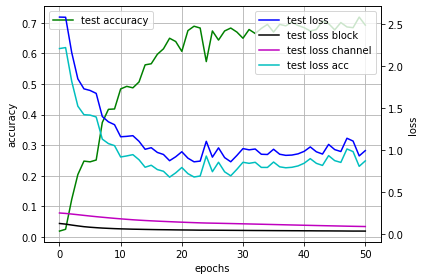

In [13]:
plot_train_phase_new("/media/eddy/datasets/models/new/birdnet_final.pt", "")

Train Phase of Modell with gamma=0.5, delta=0.5 in separated modus

0.5363528009535161


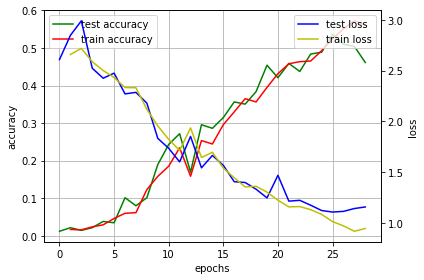

In [12]:
plot_train_phase("/media/eddy/datasets/models/birdnet_g5_d5_sep/birdnet_final.pt", "images/birdnet_g5_d5_sep")

5760


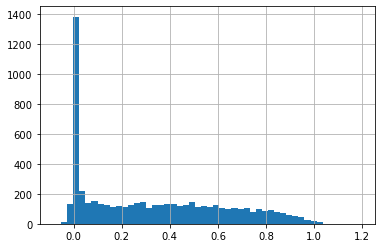

In [13]:
plot_hist("/media/eddy/datasets/models/birdnet_g5_d5_tog/birdnet_final.pt", "images/birdnet_g5_d5_tog_channel_hist")

5760


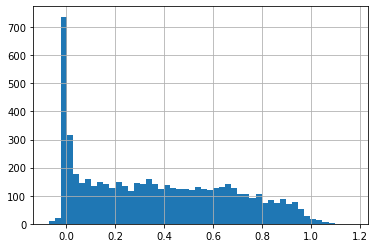

In [14]:
plot_hist("/media/eddy/datasets/models/birdnet_g5_d5_sep/birdnet_final.pt", "images/birdnet_g5_d5_sep_channel_hist")

1158


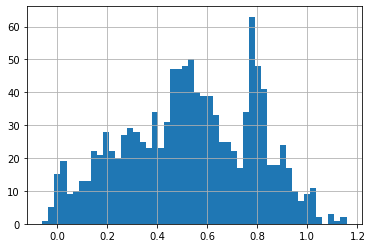

In [15]:
plot_hist("/media/eddy/datasets/models/birdnet_g5_d5_tog/channel/MIN/pruned_c80_b00_MIN/birdnet_final.pt", "images/birdnet_g5_d5_tog_pruned_c80_b00_MIN_channel_hist")

1159


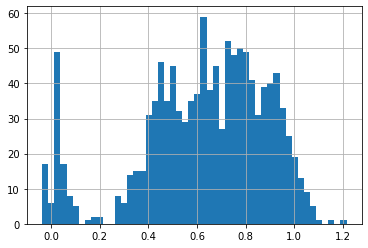

In [16]:
plot_hist("/media/eddy/datasets/models/birdnet_g5_d5_sep/channel/pruned_c80_b00_MIN/birdnet_final.pt", "images/birdnet_g5_d5_sep_pruned_c80_b00_MIN_channel_hist")

In [17]:
def plot_accuracy_and_model_size_for_pruned_batch(path, path_baseline, epoch, channel_or_block="channel"):
    folders = os.listdir(path)
    folders = sorted(folders)
    folders = filter(lambda elem: os.path.isdir(path + elem + "/"),folders)
    files = []
    test_acc = []
    train_acc = []
    test_loss = []
    train_loss = []
    size = []
    baseline = torch.load(path_baseline)
    baseline_acc = baseline['test_acc_list'][-1]
    baseline_size = count_parameters(baseline['model_state_dict'])
    size.append(baseline_size)
    
    x = []
    x.append(0)
    for elem in folders:
        if channel_or_block == "channel":
            pattern = re.compile("c[0-9]+")
        else: 
            pattern = re.compile("b[0-9]+")
        result = pattern.search(elem)
        x.append(int(result[0][1:]))
        files.append(path + elem + "/birdnet_final.pt")
    
    print(x)
        
    for file in files: 
        checkpoint = torch.load(file)
        test_acc.append(np.array(checkpoint['test_acc_list']))
        train_acc.append(np.array(checkpoint['train_acc_list']))
        test_loss.append(np.array(checkpoint['test_loss_list']))
        train_loss.append(np.array(checkpoint['train_loss_list']))
        size.append(count_parameters(checkpoint['model_state_dict']))
    
    y = []
    
    y.append(baseline_acc)
    for elem in test_acc:
        if epoch < len(elem):
            y.append(elem[epoch])
        else: 
            y.append(elem[-1])
    print(y)
    print(size)
    #x = [i for i in range(0, 110, 10)]
    fig, ax1 = plt.subplots()
    plt.title(f'Test accuracy of pruned models after {epoch} epoch(s)')
    
    plt.grid(axis='both')
    ax1.set_xlabel('prune ratio')
    ax1.set_ylabel('accuracy')
    
    ax1.plot(x, y, color='g')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('num parameters')  # we already handled the x-label with ax1
    ax2.plot(x, size, color='b')
    ax1.legend(['accuracy'], loc='lower left')
    ax2.legend(['parameters'], loc='upper right')
    #plt.xticks(list(range(0, len(x), 2)))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(path + f"acc_model_size_epoch_{epoch}")

Resstack 1: Resblock 1:  154240 Param  
Resstack 1: Resblock 2:  205568 Param  
Resstack 1: Resblock 3:  205568 Param  
Resstack 2: Resblock 1:  222464 Param  
Resstack 2: Resblock 2:  296448 Param  
Resstack 2: Resblock 3:  296448 Param  
Resstack 3: Resblock 1:  939937 Param  
Resstack 3: Resblock 2: 1245729 Param  
Resstack 3: Resblock 3: 1245729 Param  
Resstack 4: Resblock 1: 3544064 Param  
Resstack 4: Resblock 2: 4724736 Param  
Resstack 4: Resblock 3: 4724736 Param  
Sum: 17805667  
DS Block 1:   4480  
DS Block 2:  17664  
DS Block 3:  70144  
DS Block 4: 279552  
ClassificationPath: 10794496  

Total: 28,789,491

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


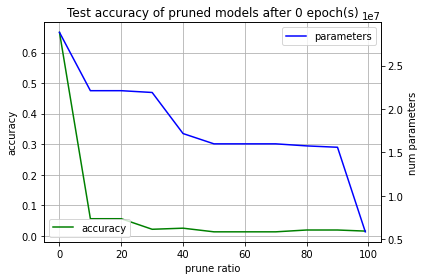

In [18]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/block/", path_full_together, 0, channel_or_block="block")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


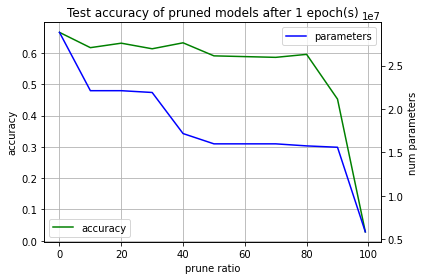

In [19]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/block/", path_full_together, 1, channel_or_block="block")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


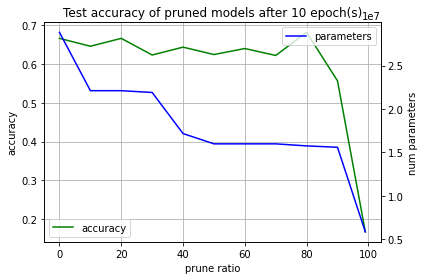

In [20]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/block/", path_full_together, 10, channel_or_block="block")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


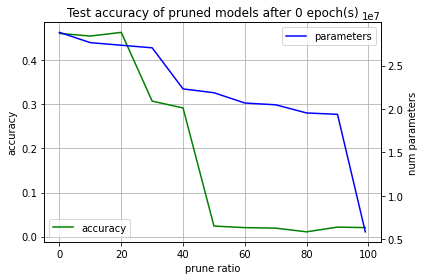

In [21]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_sep/block/", path_full_separated, 0, channel_or_block="block")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


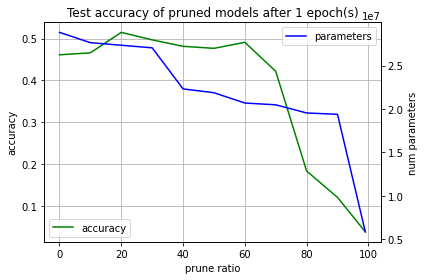

In [22]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_sep/block/", path_full_separated, 1, channel_or_block="block")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


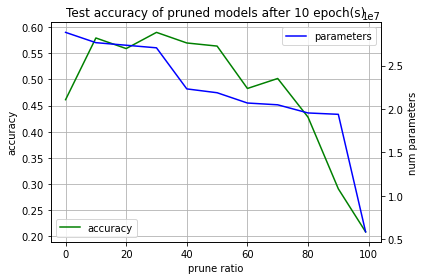

In [23]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_sep/block/", path_full_separated, 10, channel_or_block="block")

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


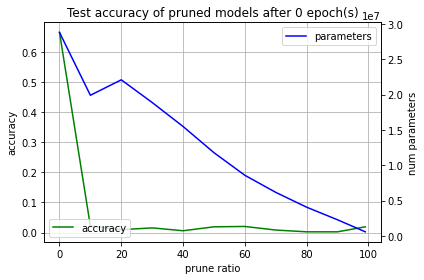

In [24]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/channel/MIN/", path_full_together, 0)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


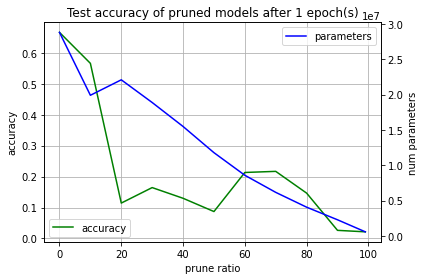

In [25]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/channel/MIN/", path_full_together, 1)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


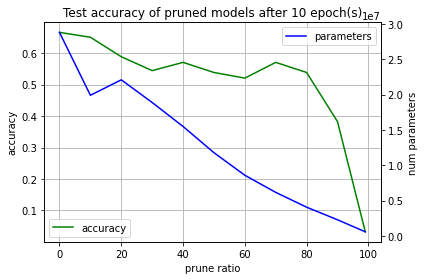

In [26]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/channel/MIN/", path_full_together, 10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]


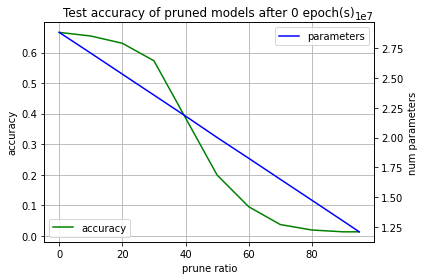

In [27]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/channel/NO_PADD/", path_full_together, 0)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]


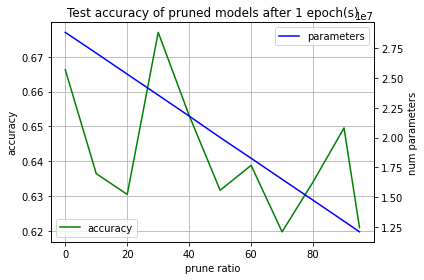

In [28]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/channel/NO_PADD/", path_full_together, 1)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]


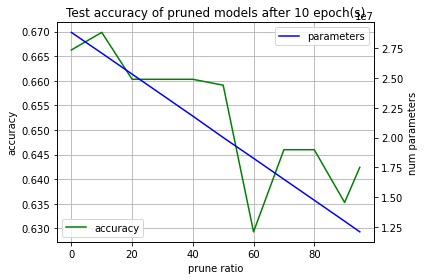

In [29]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/channel/NO_PADD/", path_full_together, 10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


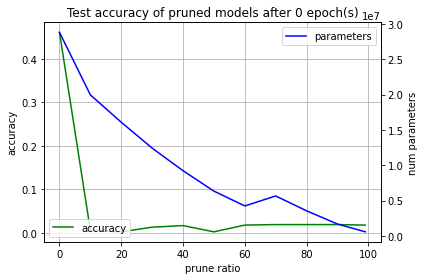

In [30]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_sep/channel/", path_full_separated, 0)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


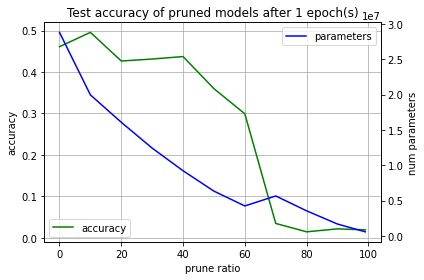

In [31]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_sep/channel/", path_full_separated, 1)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


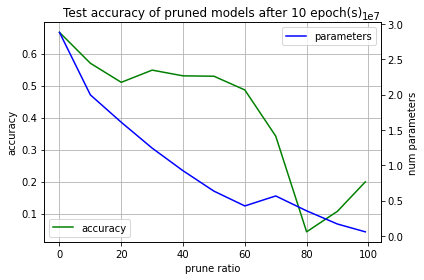

In [32]:
plot_accuracy_and_model_size_for_pruned_batch( path + "birdnet_g5_d5_sep/channel/", path_full_together, 10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98]


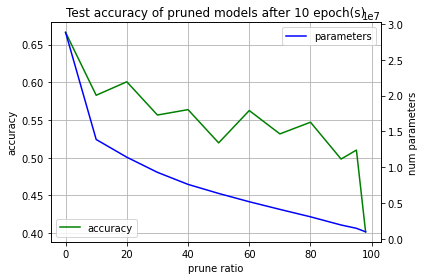

In [33]:
plot_accuracy_and_model_size_for_pruned_batch( path + "birdnet_g5_d5_tog/both/simultaneously/block_80_MIN/", path_full_together, 10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98]


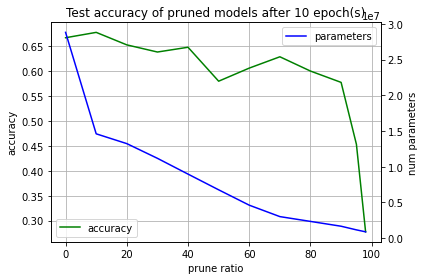

In [34]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/both/successively/", path_full_together, 10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 98, 99]
[0.66626936829559, 0.5828367103694875, 0.600715137067938, 0.5566150178784267, 0.5637663885578069, 0.5196662693682956, 0.5625744934445769, 0.531585220500596, 0.5470798569725864, 0.49821215733015495, 0.5101311084624554, 0.40166865315852207, 0.30870083432657924]
[28811911, 13872975, 11404472, 9294379, 7612595, 6351504, 5193494, 4126879, 3091220, 1949004, 1488373, 997539, 807753]


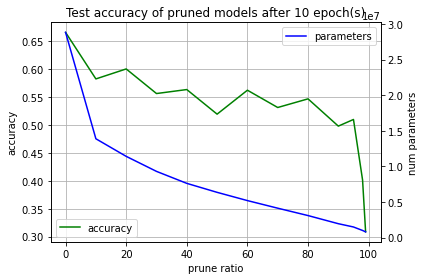

In [18]:
plot_accuracy_and_model_size_for_pruned_batch(path + "birdnet_g5_d5_tog/both/simultaneously/block_80_MIN/", path_full_together, 10)

In [46]:
def plot_train_process_for_all(path):
    elements = os.listdir(path)
    folders = filter(lambda elem: os.path.isdir(path + elem + "/"), elements)
    for folder in folders:
        plot_train_process_for_all(path + folder + "/")
    if "birdnet_final.pt" in elements:
        #plot_hist(path + "birdnet_final.pt", path + "hist")
        #plot_train_phase(path + "birdnet_final.pt", path + "train_phase")
        plot_distribution_layer_wise(path + "birdnet_final.pt", path + "dist_layer_wise")

0.44934445768772346


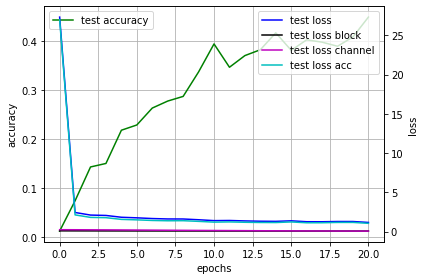

In [27]:
plot_train_phase_new("/media/eddy/datasets/models/birdnet_g5_d5_tog/both/simultaneously/pruned_c99_b80_MIN/birdnet_final.pt")

0.5137067938021455


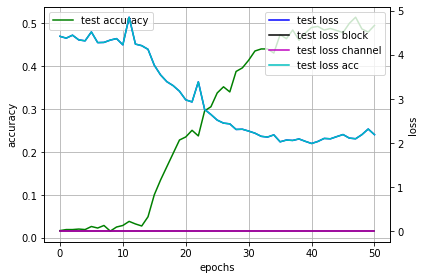

In [13]:
plot_train_phase_new("/media/eddy/datasets/models/new_shape/org_birdnet/birdnet_final.pt", "images/original")

0.7222884386174017


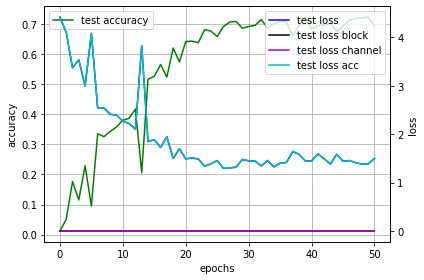

In [14]:
plot_train_phase_new("/media/eddy/datasets/models/new_shape/no_maxpool/birdnet_final.pt", "images/no_maxpool")

0.7532777115613826


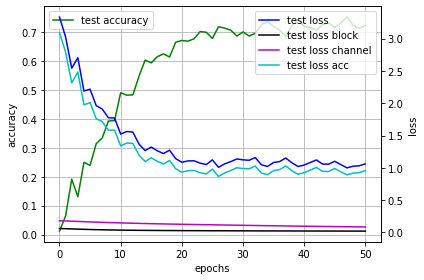

In [15]:
plot_train_phase_new("/media/eddy/datasets/models/new_shape/delta03_gamma04/birdnet_final.pt", "images/no_maxpool_gamma04_delta03")

In [17]:
checkpoint = torch.load("/media/eddy/datasets/models/birdnet_g5_d5_tog/both/simultaneously/block_80_MIN/pruned_c99_b80_MIN/birdnet_v0.pt")
state_dict = checkpoint['model_state_dict']
count_parameters(state_dict)

807753

In [18]:
checkpoint = torch.load("/media/eddy/datasets/models/mobile_net/birdnet_v0.pt")
state_dict = checkpoint['model_state_dict']
count_parameters(state_dict)

303047

In [12]:
model_summary("/media/eddy/datasets/models/birdnet_g5_d5_tog/both/simultaneously/block_80_MIN/pruned_c98_b80_MIN/birdnet_v0.pt")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 512]              64
              ReLU-2          [-1, 32, 64, 512]               0
       BatchNorm2d-3          [-1, 32, 64, 512]              64
        InputLayer-4          [-1, 32, 64, 512]               0
           Softmax-5                       [-1]               0
         MaxPool2d-6          [-1, 32, 32, 256]               0
            Conv2d-7          [-1, 32, 32, 256]           1,056
            Conv2d-8          [-1, 16, 64, 512]             528
       BatchNorm2d-9          [-1, 16, 64, 512]              32
             ReLU-10          [-1, 16, 64, 512]               0
           Conv2d-11          [-1, 16, 64, 512]           6,416
      BatchNorm2d-12          [-1, 16, 64, 512]              32
             ReLU-13          [-1, 16, 64, 512]               0
        MaxPool2d-14          [-1, 16, 

5760


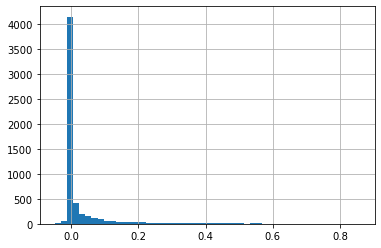

In [11]:
plot_hist("/media/eddy/datasets/models/birdnet_g05_d09_tog/birdnet_final.pt", "")